In [2]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_all_bd_20ms import XBOX2TrendAllBD20msSelect
from src.dataset_creator import load_dataset, data_array_to_numpy
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer

# Load Dataset
To load a dataset the dataset name and path to data has to be supplied.
This information is then passed to the `load_dataset` function which returns training, validation and test set.

For the xbox2 dataset some additional information is passed to the dataset loader.
First, the `manual_split` argument can be used to specify custom splitting of the data using run numbers.
Secondly, the `manual_scale` argument can be used to specify if scaling should
be done using mean and standard deviation of each run.

In [3]:
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")

train, valid, test = load_dataset(creator=XBOX2TrendAllBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=[1, 2, 3, 4, 5, 6, 7, 8, 9])

# Plot Dataset
A good sanity check is to plot the data and checking if the data looks as expected.

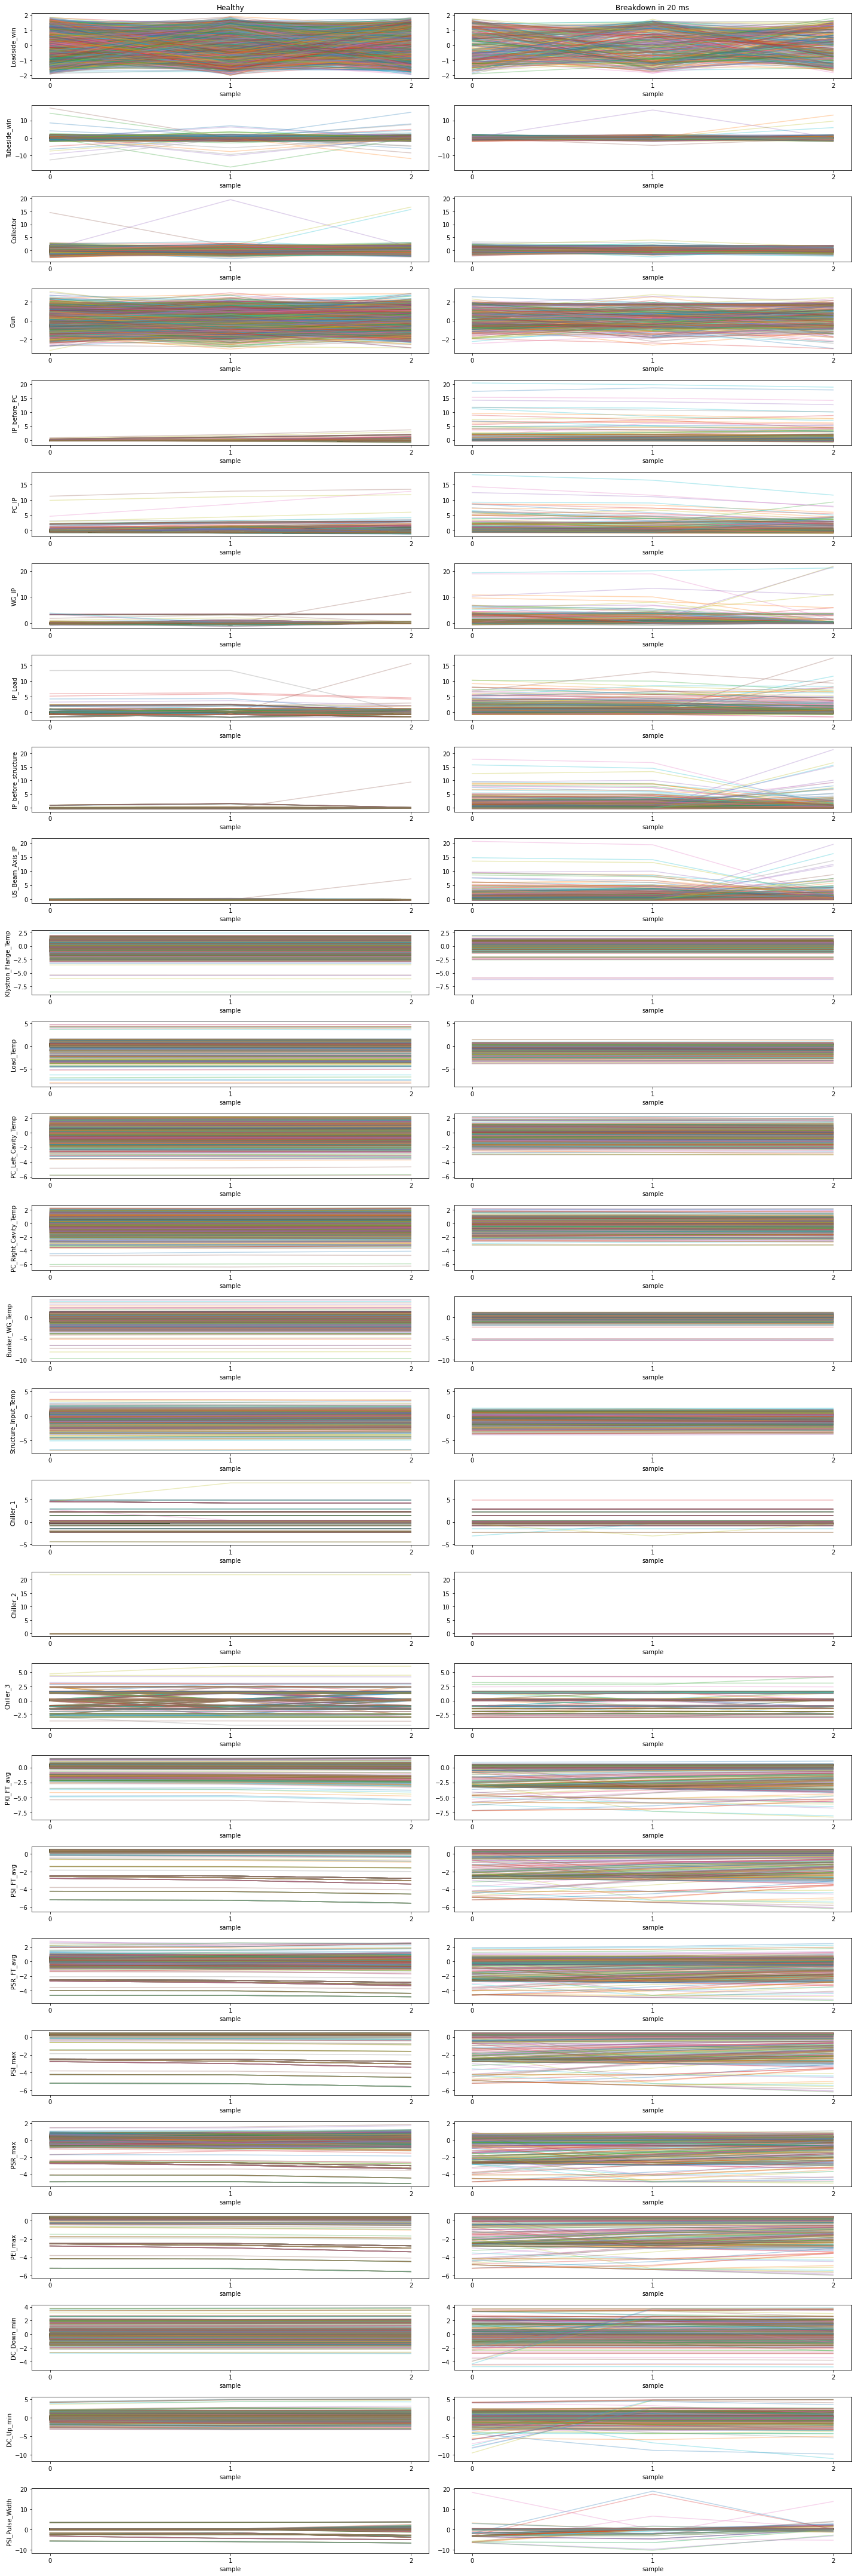

In [4]:
n_features = len(train.X.feature)

fig, ax = plt.subplots(n_features,2, figsize=(20,60))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.values.argmax(axis=1) == 0][:,:,i].values.T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(train.X.feature[i].values)
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.values.argmax(axis=1) == 1][:,:,i].values.T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays.
This can be done manually or using the helper function found in the dataset_creator module.

In [7]:
train_numpy, valid_numpy, test_numpy = data_array_to_numpy(train, valid, test)

# Create and Use Classifier Model
To create a classifier model an instance of the `Classifier` class is created.
To do this some hyperparameter settings are needed. These are loaded from a ´.json´ file.
We also need to pass the input shape and the directory to put model outputs.

In [8]:
# Load hyperparameters into dictionary
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# Create model
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

## Fit Model
After the model is created it has to be fitted to the data. This is done using the `fit_classifier` method.
Alternatively if a model already has been trained, the trained weights can be loaded.
It is faster to simply load pretrained weights as training is time-consuming.

In [9]:
# Fit model to training set and validate on validation set
clf.fit_classifier(train_numpy, valid_numpy)

Epoch 1/500
138/138 [==============================] - 4s 27ms/step - loss: 0.3835 - tp: 1921.0000 - fp: 273.0000 - tn: 1921.0000 - fn: 273.0000 - accuracy: 0.8756 - precision: 0.8756 - recall: 0.8756 - auc: 0.9327 - prc: 0.9254 - val_loss: 0.3467 - val_tp: 587.0000 - val_fp: 37.0000 - val_tn: 587.0000 - val_fn: 37.0000 - val_accuracy: 0.9407 - val_precision: 0.9407 - val_recall: 0.9407 - val_auc: 0.9682 - val_prc: 0.9549
Epoch 2/500
138/138 [==============================] - 2s 16ms/step - loss: 0.2614 - tp: 2054.0000 - fp: 140.0000 - tn: 2054.0000 - fn: 140.0000 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9718 - prc: 0.9689 - val_loss: 0.3535 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9553 - val_prc: 0.9387
Epoch 3/500
138/138 [==============================] - 2s 16ms/step - loss: 0.2195 - tp: 2083.0000 - fp: 111.0000 - tn: 2083.0000 - fn: 111.0000 - a

138/138 [==============================] - 2s 17ms/step - loss: 0.0144 - tp: 2180.0000 - fp: 14.0000 - tn: 2180.0000 - fn: 14.0000 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9994 - prc: 0.9993 - val_loss: 0.6722 - val_tp: 558.0000 - val_fp: 66.0000 - val_tn: 558.0000 - val_fn: 66.0000 - val_accuracy: 0.8942 - val_precision: 0.8942 - val_recall: 0.8942 - val_auc: 0.9352 - val_prc: 0.9197
Epoch 21/500
138/138 [==============================] - 2s 16ms/step - loss: 0.0116 - tp: 2185.0000 - fp: 9.0000 - tn: 2185.0000 - fn: 9.0000 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9994 - prc: 0.9993 - val_loss: 0.6424 - val_tp: 573.0000 - val_fp: 51.0000 - val_tn: 573.0000 - val_fn: 51.0000 - val_accuracy: 0.9183 - val_precision: 0.9183 - val_recall: 0.9183 - val_auc: 0.9524 - val_prc: 0.9402
Epoch 22/500
138/138 [==============================] - 2s 17ms/step - loss: 0.0232 - tp: 2175.0000 - fp: 19.0000 - tn: 2175.0000 - fn: 19.0000 - accuracy: 0.9913 - 

138/138 [==============================] - 2s 16ms/step - loss: 8.2502e-06 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.5603 - val_tp: 569.0000 - val_fp: 55.0000 - val_tn: 569.0000 - val_fn: 55.0000 - val_accuracy: 0.9119 - val_precision: 0.9119 - val_recall: 0.9119 - val_auc: 0.9382 - val_prc: 0.9221
Epoch 40/500
138/138 [==============================] - 2s 17ms/step - loss: 6.8473e-06 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.6007 - val_tp: 569.0000 - val_fp: 55.0000 - val_tn: 569.0000 - val_fn: 55.0000 - val_accuracy: 0.9119 - val_precision: 0.9119 - val_recall: 0.9119 - val_auc: 0.9367 - val_prc: 0.9202
Epoch 41/500
138/138 [==============================] - 2s 16ms/step - loss: 5.7751e-06 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 

Epoch 58/500
138/138 [==============================] - 2s 17ms/step - loss: 7.9381e-07 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.0580 - val_tp: 571.0000 - val_fp: 53.0000 - val_tn: 571.0000 - val_fn: 53.0000 - val_accuracy: 0.9151 - val_precision: 0.9151 - val_recall: 0.9151 - val_auc: 0.9376 - val_prc: 0.9212
Epoch 59/500
138/138 [==============================] - 2s 16ms/step - loss: 7.2435e-07 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.0815 - val_tp: 571.0000 - val_fp: 53.0000 - val_tn: 571.0000 - val_fn: 53.0000 - val_accuracy: 0.9151 - val_precision: 0.9151 - val_recall: 0.9151 - val_auc: 0.9376 - val_prc: 0.9212
Epoch 60/500
138/138 [==============================] - 2s 16ms/step - loss: 6.6035e-07 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 219

Epoch 77/500
138/138 [==============================] - 2s 16ms/step - loss: 1.5401e-07 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.4313 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 78/500
138/138 [==============================] - 2s 17ms/step - loss: 1.4238e-07 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.4520 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 79/500
138/138 [==============================] - 2s 16ms/step - loss: 1.3074e-07 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 219

Epoch 96/500
138/138 [==============================] - 2s 14ms/step - loss: 5.0882e-08 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.6709 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9354 - val_prc: 0.9184
Epoch 97/500
138/138 [==============================] - 2s 13ms/step - loss: 4.7548e-08 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.6833 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9340 - val_prc: 0.9165
Epoch 98/500
138/138 [==============================] - 2s 14ms/step - loss: 4.5010e-08 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 219

Epoch 115/500
138/138 [==============================] - 2s 16ms/step - loss: 1.6568e-08 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.8922 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9329 - val_prc: 0.9152
Epoch 116/500
138/138 [==============================] - 2s 16ms/step - loss: 1.5613e-08 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.9046 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9330 - val_prc: 0.9153
Epoch 117/500
138/138 [==============================] - 2s 15ms/step - loss: 1.4708e-08 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 134/500
138/138 [==============================] - 2s 16ms/step - loss: 4.6247e-09 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.0940 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9334 - val_prc: 0.9158
Epoch 135/500
138/138 [==============================] - 2s 16ms/step - loss: 4.4307e-09 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.0990 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9334 - val_prc: 0.9158
Epoch 136/500
138/138 [==============================] - 2s 16ms/step - loss: 4.2691e-09 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 153/500
138/138 [==============================] - 2s 16ms/step - loss: 1.9158e-09 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.1784 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9337 - val_prc: 0.9162
Epoch 154/500
138/138 [==============================] - 2s 16ms/step - loss: 1.7455e-09 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.1811 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9337 - val_prc: 0.9162
Epoch 155/500
138/138 [==============================] - 2s 16ms/step - loss: 1.6485e-09 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 172/500
138/138 [==============================] - 2s 12ms/step - loss: 7.1112e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.2453 - val_tp: 577.0000 - val_fp: 47.0000 - val_tn: 577.0000 - val_fn: 47.0000 - val_accuracy: 0.9247 - val_precision: 0.9247 - val_recall: 0.9247 - val_auc: 0.9338 - val_prc: 0.9162
Epoch 173/500
138/138 [==============================] - 2s 12ms/step - loss: 7.1112e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.2489 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9162
Epoch 174/500
138/138 [==============================] - 2s 15ms/step - loss: 7.1112e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 191/500
138/138 [==============================] - 2s 15ms/step - loss: 3.2324e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.2894 - val_tp: 575.0000 - val_fp: 49.0000 - val_tn: 575.0000 - val_fn: 49.0000 - val_accuracy: 0.9215 - val_precision: 0.9215 - val_recall: 0.9215 - val_auc: 0.9338 - val_prc: 0.9162
Epoch 192/500
138/138 [==============================] - 2s 16ms/step - loss: 3.2324e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.2905 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9162
Epoch 193/500
138/138 [==============================] - 2s 17ms/step - loss: 3.2324e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 210/500
138/138 [==============================] - 2s 16ms/step - loss: 1.2929e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3087 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9337 - val_prc: 0.9162
Epoch 211/500
138/138 [==============================] - 2s 16ms/step - loss: 1.2929e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3094 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9162
Epoch 212/500
138/138 [==============================] - 2s 15ms/step - loss: 1.2929e-10 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 229/500
138/138 [==============================] - 2s 15ms/step - loss: 6.4647e-11 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3212 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 230/500
138/138 [==============================] - 2s 15ms/step - loss: 6.4647e-11 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3223 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9163
Epoch 231/500
138/138 [==============================] - 2s 15ms/step - loss: 6.4647e-11 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 248/500
138/138 [==============================] - 2s 16ms/step - loss: 3.2324e-11 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3294 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9163
Epoch 249/500
138/138 [==============================] - 2s 16ms/step - loss: 3.2324e-11 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3298 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9163
Epoch 250/500
138/138 [==============================] - 2s 17ms/step - loss: 3.2324e-11 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 267/500
138/138 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3348 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9163
Epoch 268/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3352 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9338 - val_prc: 0.9163
Epoch 269/500
138/138 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 286/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3390 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 287/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3392 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 288/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 305/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3429 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 306/500
138/138 [==============================] - 2s 17ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3431 - val_tp: 576.0000 - val_fp: 48.0000 - val_tn: 576.0000 - val_fn: 48.0000 - val_accuracy: 0.9231 - val_precision: 0.9231 - val_recall: 0.9231 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 307/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 324/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3458 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 325/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3461 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 326/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 343/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3488 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 344/500
138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3490 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 345/500
138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 362/500
138/138 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3518 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 363/500
138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3520 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 364/500
138/138 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 381/500
138/138 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3545 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 382/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3546 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 383/500
138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 400/500
138/138 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3570 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 401/500
138/138 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3571 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 402/500
138/138 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 419/500
138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3594 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 420/500
138/138 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3595 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9339 - val_prc: 0.9163
Epoch 421/500
138/138 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 438/500
138/138 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3620 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9340 - val_prc: 0.9165
Epoch 439/500
138/138 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3621 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9340 - val_prc: 0.9165
Epoch 440/500
138/138 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 457/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3642 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 458/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3644 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 459/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 476/500
138/138 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3661 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 477/500
138/138 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3663 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 478/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

Epoch 495/500
138/138 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3682 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 496/500
138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 2194.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 3.3684 - val_tp: 578.0000 - val_fp: 46.0000 - val_tn: 578.0000 - val_fn: 46.0000 - val_accuracy: 0.9263 - val_precision: 0.9263 - val_recall: 0.9263 - val_auc: 0.9354 - val_prc: 0.9183
Epoch 497/500
138/138 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - tp: 2194.0000 - fp: 0.0000e+00 - tn: 

## Make Prediction
When the model has been fitted to the data, it can be used to make predictions.
Here the prediction is done on the kept out test set using the `predict` method.

In [10]:
y_pred = clf.model.predict(x=test_numpy.X)
y_pred

array([[1.0000000e+00, 3.6888682e-17],
       [1.0000000e+00, 5.6454744e-22],
       [1.0000000e+00, 1.1630759e-18],
       ...,
       [1.0000000e+00, 7.1233085e-28],
       [1.0000000e+00, 9.7378246e-27],
       [1.0000000e+00, 8.9267040e-18]], dtype=float32)

## Evaluate Model
To evaluate the performance of the model, the `evaluate` method can be used.

In [11]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

21/21 [==============================] - 0s 6ms/step - loss: 3.2737 - tp: 604.0000 - fp: 39.0000 - tn: 604.0000 - fn: 39.0000 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9461 - prc: 0.9313  


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,3.273659,604.0,39.0,604.0,39.0,0.939347,0.939347,0.939347,0.946054,0.931331


# Explanation
After training the model we now wish to explain the predictions of the model.
This can be done using explainers such as the SHAP gradient explainer.

## Make prediction
To explain a prediction we first make predictions on the test set

In [12]:
y_pred = clf.model.predict(x=test_numpy.X)

We then use `explain_samples` to explain the samples.
In this example we use the SHAP gradient explainer.

In [13]:
is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

Using TensorFlow backend.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
To explain which features are most important for the explanation, 
we can take the global mean of the shap values for each feature. 
To visualize the explanation we can plot this in a barplot. 

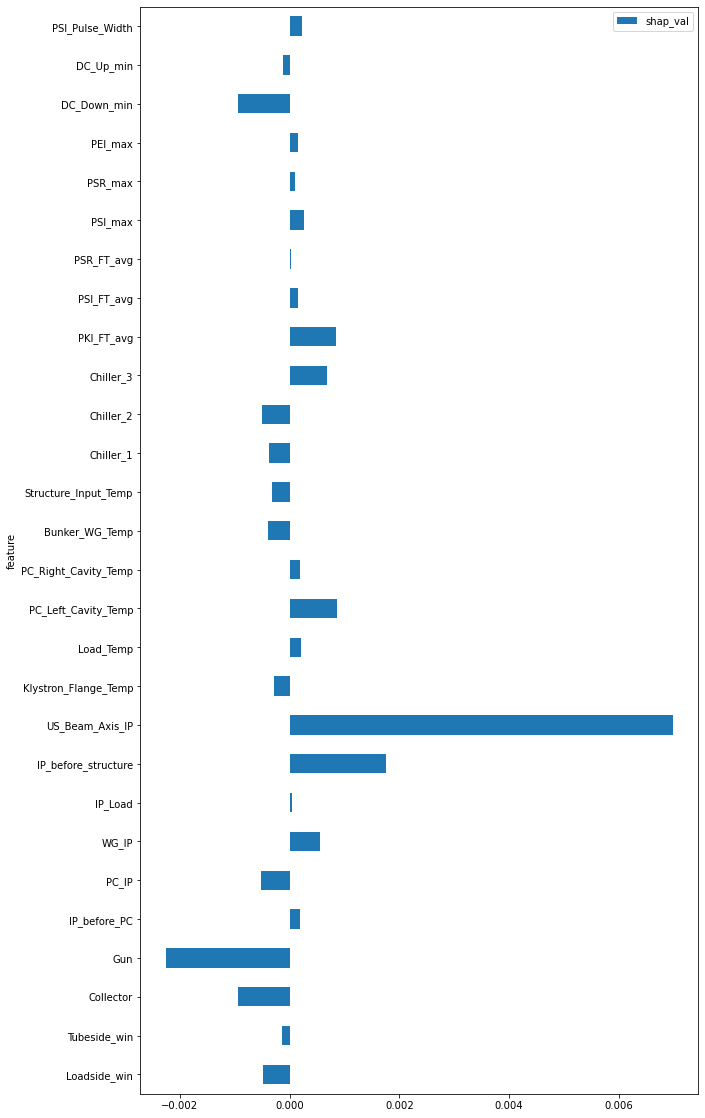

In [16]:
ex_global = np.mean(np.mean(ex_classification[1], axis=0), axis=0)
df = pd.DataFrame({'feature': test.X.feature.values, 'shap_val': ex_global})
ax = df.plot.barh(x='feature', y='shap_val', figsize=(10,20))

In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
Here, overlay color is determined by the shap value.